<a href="https://colab.research.google.com/github/GustavoGran/ecommerce_recomender/blob/main/ptc3467_caracterizacao_dados_ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importação de bibliotecas**

In [6]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn as sns

## **Importação dos datasets**

In [7]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/Colab Notebooks/datasets/olist_ecommerce"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/datasets/olist_ecommerce


In [8]:
customers_file_name = 'olist_customers_dataset.csv'
orders_file_name = 'olist_orders_dataset.csv'
geolocation_file_name = 'olist_geolocation_dataset.csv'
products_file_name = 'olist_products_dataset.csv'
order_items_file_name = 'olist_order_items_dataset.csv'
sellers_file_name = 'olist_sellers_dataset.csv'
order_payments_file_name = 'olist_order_payments_dataset.csv'
product_translation_file_name = 'product_category_name_translation.csv'
order_reviews_file_name = 'olist_order_reviews_dataset.csv'

In [9]:
df_customers = pd.read_csv(customers_file_name,sep=',')
df_orders = pd.read_csv(orders_file_name,sep=',')
df_geolocation = pd.read_csv(geolocation_file_name,sep=',')
df_products = pd.read_csv(products_file_name,sep=',')
df_order_items = pd.read_csv(order_items_file_name,sep=',')
df_sellers = pd.read_csv(sellers_file_name,sep=',')
df_order_payments = pd.read_csv(order_payments_file_name,sep=',')
df_order_reviews = pd.read_csv(order_reviews_file_name,sep=',')

# **Entendendo a origem dos clientes do e-commerce**

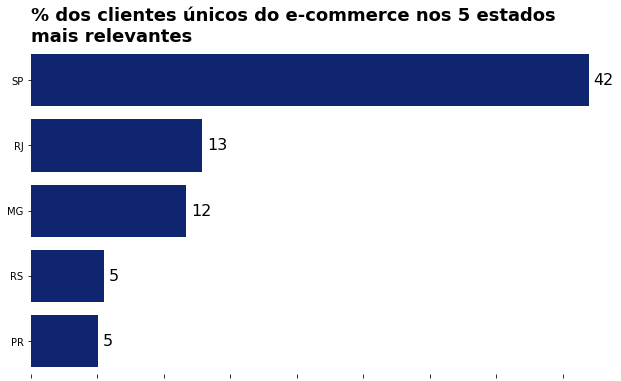

In [10]:
customer_states = df_customers.groupby('customer_state')
unique_customers_by_state = customer_states.customer_unique_id.nunique().sort_values(ascending=False).to_frame()

unique_customers_by_state['customer_state'] = unique_customers_by_state.index
unique_customers_by_state['perc_total_customers'] = unique_customers_by_state.customer_unique_id *(100 / df_customers.customer_unique_id.nunique())

f, ax = plt.subplots(figsize=(10,6))
sns.set_color_codes("dark")

splot = sns.barplot(x="perc_total_customers", y="customer_state", data=unique_customers_by_state.head(5), color="b")

# Add annotations of values
for p in ax.patches:
    ax.annotate("%.f" % p.get_width(), xy=(p.get_width(), p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center", size = 16)

# Add a legend and informative axis label

ax.set(xlim=(0, max(unique_customers_by_state['perc_total_customers'])), 
       xlabel='', ylabel='', xticklabels=[])

ax.set_title("% dos clientes únicos do e-commerce nos 5 estados \nmais relevantes",
             size=18,fontweight="bold",loc = 'left')
ax.grid(False)
sns.despine(offset=10, trim=True, left=True, bottom=True);
plt.show()

# **Integração dos dados**
* **df_customer_orders:** agrupará informações de clientes, dados gerais das compras e avaliações dos clientes
* **df_order_products:** agrupará informações de produtos por compra e informações gerais do produto

In [11]:
# Selects only the most recent review for each order
df_latest_order_reviews = df_order_reviews.groupby('order_id', as_index=False).agg({'review_answer_timestamp' : 'first'})
df_order_reviews = pd.merge(left=df_order_reviews[['order_id','review_answer_timestamp','review_score']], 
                            right= df_latest_order_reviews, on=['order_id','review_answer_timestamp'], how='inner')

customer_cols = ['customer_id','customer_unique_id', 'customer_state']
order_cols = ['customer_id','order_id','order_purchase_timestamp']
review_cols = ['order_id','review_score']

df_customer_orders = pd.merge(
    pd.merge(df_customers[customer_cols], df_orders[order_cols], how='inner', on="customer_id", validate="one_to_one"),
    df_order_reviews[review_cols],
    how='inner', on="order_id",validate="one_to_one")

df_order_products = pd.merge(df_order_items,df_products,how='inner',on='product_id')

In [12]:
# Add number of order items and sum of items price per order

df_grouped_orders = df_order_products.groupby('order_id', as_index=False).agg(
    {'product_id' : ['count','nunique'], 'price' : 'sum'})
df_grouped_orders.columns = ['order_id', 'number_of_items','number_of_unique_items','sum_of_item_prices']

df_customer_orders = pd.merge(df_customer_orders,df_grouped_orders, how='inner', on='order_id', validate="one_to_one")
df_customer_orders.head()

,customer_id,customer_unique_id,customer_state,order_id,order_purchase_timestamp,review_score,number_of_items,number_of_unique_items,sum_of_item_prices
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,4,1,1,124.99
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,SP,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,5,1,1,289.00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,5,1,1,139.94
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,SP,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,5,1,1,149.94
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,5,1,1,230.00


In [13]:
df_customer_orders.order_purchase_timestamp = pd.to_datetime(df_customer_orders.order_purchase_timestamp)

df_first_orders = df_customer_orders.groupby('customer_unique_id', as_index = False).agg(
                        {'order_purchase_timestamp':'min'})
df_first_orders.columns = ['customer_unique_id','first_purchase_timestamp']

df_customer_orders = pd.merge(df_customer_orders,df_first_orders,how='inner',on='customer_unique_id')

In [14]:
df_customer_orders['days_since_first_purchase'] = ((df_customer_orders['order_purchase_timestamp'].dt.date
                                                   - df_customer_orders['first_purchase_timestamp'].dt.date)/np.timedelta64(1,'D')).astype(int)

In [15]:
# Orders dataset in order to find last order previous than current order
df_customer_orders = df_customer_orders.sort_values(by=['customer_unique_id','order_purchase_timestamp'])
df_customer_orders.reset_index(drop=True, inplace=True)

In [16]:
# Searches dataset for last purchase date per customer
df_customer_orders.loc[df_customer_orders['days_since_first_purchase'] == 0,'last_purchase_timestamp'] = pd.to_datetime(np.nan)

for idx in df_customer_orders[df_customer_orders['days_since_first_purchase'] > 0].index:
    df_customer_orders.loc[idx, 'last_purchase_timestamp'] = df_customer_orders.loc[idx-1,'order_purchase_timestamp']

In [17]:
# Calculates number of days since last purchase per customer
df_customer_orders.loc[df_customer_orders['days_since_first_purchase'] == 0,'days_since_last_purchase'] = 0
df_customer_orders.loc[df_customer_orders['days_since_first_purchase'] > 0,'days_since_last_purchase'] = ((df_customer_orders.loc[df_customer_orders['days_since_first_purchase'] > 0,'order_purchase_timestamp'].dt.date
                                                   - df_customer_orders.loc[df_customer_orders['days_since_first_purchase'] > 0,'last_purchase_timestamp'].dt.date)/np.timedelta64(1,'D')).astype(int)

# **Descrição de dados**

In [33]:
# Describing
df_desc = df_customer_orders.describe().transpose()
df_desc['interval'] = df_desc['max'] - df_desc['min']
df_desc['IQR'] = df_desc['75%'] -  df_desc['25%']
df_desc['Lim_inf_outlier'] = df_desc['25%'] - 1.5 * df_desc['IQR']
df_desc['Lim_sup_outlier'] = df_desc['75%'] + 1.5 * df_desc['IQR']
df_desc.transpose()

,review_score,number_of_items,number_of_unique_items,sum_of_item_prices,days_since_first_purchase,days_since_last_purchase
count,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000,98666.000000
mean,4.089798,1.141731,1.038098,137.754076,2.894513,2.595109
std,1.343624,0.538452,0.226456,210.645145,26.095843,24.061107
min,1.000000,1.000000,1.000000,0.850000,0.000000,0.000000
25%,4.000000,1.000000,1.000000,45.900000,0.000000,0.000000
50%,5.000000,1.000000,1.000000,86.900000,0.000000,0.000000
75%,5.000000,1.000000,1.000000,149.900000,0.000000,0.000000
max,5.000000,21.000000,8.000000,13440.000000,633.000000,609.000000
interval,4.000000,20.000000,7.000000,13439.150000,633.000000,609.000000
IQR,1.000000,0.000000,0.000000,104.000000,0.000000,0.000000


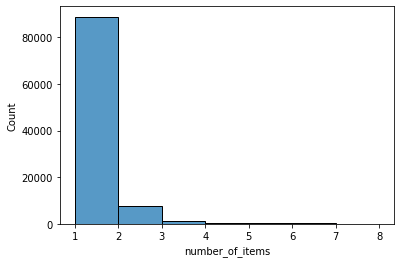

In [34]:
sns.histplot(data=df_customer_orders, x='number_of_items', stat='count',binwidth=1,binrange=(1,8))

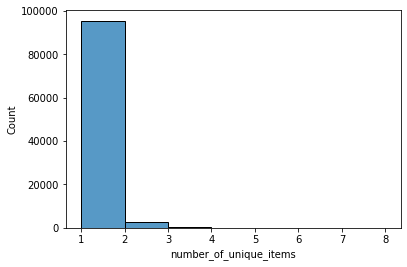

In [35]:
sns.histplot(data=df_customer_orders, x='number_of_unique_items', stat='count',binwidth=1,binrange=(1,8))

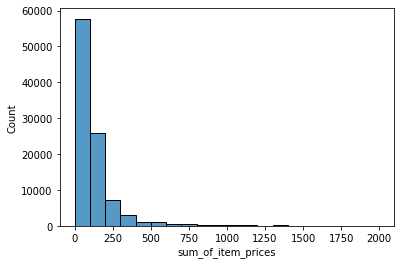

In [37]:
sns.histplot(data=df_customer_orders, x='sum_of_item_prices',binwidth=100.0,binrange=(0.0,2000.0))